In [48]:
%reset
#%matplotlib qt

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_test
from mne import io
import pickle
from os.path import exists
import gc

gc.collect()

0

In [50]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"
import_type = "5Electorodes_plainEEGLAB"

In [51]:
freq_bands = {}
freq_bands['Delta'] = {}
freq_bands['Delta']['min'] = 2
freq_bands['Delta']['max'] = 4
freq_bands['Delta']['title'] = f"Delta ({freq_bands['Delta']['min']}-{freq_bands['Delta']['max']} Hz)"

freq_bands['Theta'] = {}
freq_bands['Theta']['min'] = 4
freq_bands['Theta']['max'] = 8
freq_bands['Theta']['title'] = f"Theta ({freq_bands['Theta']['min']}-{freq_bands['Theta']['max']} Hz)"

freq_bands['Alpha'] = {}
freq_bands['Alpha']['min'] = 8
freq_bands['Alpha']['max'] = 12
freq_bands['Alpha']['title'] = f"Alpha ({freq_bands['Alpha']['min']}-{freq_bands['Alpha']['max']} Hz)"

freq_bands['Beta'] = {}
freq_bands['Beta']['min'] = 12
freq_bands['Beta']['max'] = 30
freq_bands['Beta']['title'] = f"Beta ({freq_bands['Beta']['min']}-{freq_bands['Beta']['max']} Hz)"

freq_bands['Gamma'] = {}
freq_bands['Gamma']['min'] = 30
freq_bands['Gamma']['max'] = 45
freq_bands['Gamma']['title'] = f"Gamma ({freq_bands['Gamma']['min']}-{freq_bands['Gamma']['max']} Hz)"

## Import epochs

In [61]:
with open(f'{epochs_dir}\\{import_type}.pkl', 'rb') as file:
    [allEvents_df, allEpochs_perCond, cfg] = pickle.load(file)

cfg['sample_freq'] = 250

max_freq  =cfg['sample_freq']/2
times = cfg['times'] *0.0001
time0_i = np.where(times==0)[0][0]
hz_y = np.fft.rfftfreq(len(times[time0_i:]), 1.0/cfg['sample_freq'])

In [53]:
allEvents_df

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesAmount,Epoch_eeglab_ids,TOA_cond
0,0,08,Wn,T,650,0,24,"[142, 262, 422, 682, 942, 1062, 1262, 1582, 16...",T
1,1,08,Wn,T,650,1,24,"[144, 264, 424, 684, 944, 1064, 1264, 1584, 16...",T
2,2,08,Wn,T,650,2,24,"[146, 266, 426, 686, 946, 1066, 1266, 1586, 16...",T
3,3,08,Wn,T,650,3,24,"[148, 268, 428, 688, 948, 1068, 1268, 1588, 16...",T
4,4,08,Wn,T,650,4,24,"[150, 270, 430, 690, 950, 1070, 1270, 1590, 16...",T
...,...,...,...,...,...,...,...,...,...
30235,30235,38,REM,A,5302,5,0,[],A
30236,30236,38,REM,A,5302,6,0,[],A
30237,30237,38,REM,A,5302,7,0,[],A
30238,30238,38,REM,A,5302,8,0,[],A


In [54]:
example_subject = '32'
example_epochs_filename = f"epochs_Wn_s{example_subject}_file"
data_path = 'C:\AnatArzData\Data\\reref'
subject_setfile_wake_n = data_path + '\s_32_wake_night_referenced.set'

if exists(example_epochs_filename):
    with open(example_epochs_filename, 'rb') as config_dictionary_file:
        epochs_Wn_example_sub = pickle.load(config_dictionary_file)
        #print(epochs_Wn_example_sub)
else:
    epochs_Wn_example_sub = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,eog=(),verbose=None, uint16_codec=None)
    with open(example_epochs_filename, 'wb') as epochs_Wn_s_example_file:
        pickle.dump(epochs_Wn_example_sub, epochs_Wn_s_example_file)

montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
epochs_Wn_example_sub_piked = epochs_Wn_example_sub.pick_channels(cfg['ch_names'])
epochs_Wn_example_sub_monatged = epochs_Wn_example_sub_piked.set_montage(montage)
info = epochs_Wn_example_sub_monatged.info

In [55]:
# ## Import allEpochs_perCond_freq
# frq_filename = f'{epochs_dir}\\{import_type}_frq.pkl'
#
# if exists(frq_filename):
#     with open(frq_filename, 'rb') as config_dictionary_file:
#         allEpochs_perCond_freq = pickle.load(config_dictionary_file)
#         #print(allEpochs_perCond_freq)
# else:
#     allEpochs_perCond_freq = {}
#     for key in allEpochs_perCond:
#         allEpochs_perCond_freq[key] = np.zeros((len(cfg['electrodes']),len(hz_y),allEpochs_perCond[key].shape[2]))
#         for el in range(len(cfg['electrodes'])):
#             for tr in range(allEpochs_perCond[key].shape[2]):
#                 curr_trial_in_electr = allEpochs_perCond[key][el,time0_i:,tr]
#                 fft_abs = np.absolute(np.fft.rfft(curr_trial_in_electr))
#                 fft_norm = (fft_abs- np.min(fft_abs)) / (np.max(fft_abs) - np.min(fft_abs))
#                 allEpochs_perCond_freq[key][el,:,tr] = fft_norm
#     with open(frq_filename, 'wb') as epochs_Wn_s_example_file:
#         pickle.dump(allEpochs_perCond_freq, epochs_Wn_s_example_file)

In [110]:
def getEpochsPerCond(cond_df,dataset):
    df_minTrials = cond_df[(cond_df.SamplesAmount > 0)] # discard cond with 0 enough samples
    keys = (str(key) for key in df_minTrials.Cond_id)
    epochs = {str_key: dataset[str_key] for str_key in keys}
    return df_minTrials, epochs

# output: [#conds, #elect, #y_ax]
def getEvokedPerCondAndElectd(constraints,dataset,y_ax,outputType='array',tmin=-0.1):
    curr_df =allEvents_df.copy()
    # apply constraints
    for key in constraints: curr_df = curr_df[(curr_df[key] == constraints[key])]

    conds_df, epochsPerCond = getEpochsPerCond(curr_df,dataset)
    evoked_perCond_andElectd = np.zeros((len(epochsPerCond),np.size(cfg['electrodes']),len(y_ax)))

    for cond_i, cond in enumerate(epochsPerCond):
        evoked_perCond_andElectd[cond_i] = np.squeeze(np.nanmean(epochsPerCond[cond],axis=2))

    if outputType =='array':
        return conds_df, evoked_perCond_andElectd
    elif outputType =='mne':
        # Epochs array shapr should be: (len(epochs_samps_per_cond),len(electrodes),len(y_ax))
        mne_epochs = mne.EpochsArray(evoked_perCond_andElectd, info,tmin=tmin,baseline=baseline)
        return conds_df, mne_epochs ## TODO: this is epochs. Maybe we need evoked.

In [57]:
# def get_evokedPerCond_ax_mneFunc(ax1,df,condName : str, condVaribles, filterConds, graphColors):
#     evokeds = {}
#     for s,subject in enumerate(subs):
#         evokeds[s] = {}
#         filterConds['Subject'] = subject
#         for val in condVaribles:
#             filterConds[condName] = val
#             curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
#             curr_subAndCond_electrOverTime /= 1e6
#             evokeds[s][val] = mne.EvokedArray(curr_subAndCond_electrOverTime,info,tmin=-0.1)
#
#     # Edit the data to mne plot format
#     evokeds_mnePlotFormat = {}
#     for val in condVaribles:
#         evokeds_mnePlotFormat[val] = []
#         for sub_i in range(len(subs)):
#             evokeds_mnePlotFormat[val].append(evokeds[sub_i][val])
#
#     plot_compare_evokeds(evokeds_mnePlotFormat,combine = 'mean',colors=graphColors,
#                          axes=ax1,show=False,truncate_xaxis=False, truncate_yaxis=False,
#                          show_sensors = False , legend='upper left')
def applyDesign(ax,title=''):
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper right',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('magnitude', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Frequency (Hz)', fontsize = 16, fontweight = 'bold')

## Time-freq functions

In [70]:
def time_freq_clustr_perm(constraints_1, constraints_2, freqs, channel,n_cycles):
    average = channel == 'mean'
    conds_df1, mne_epochs_1 = getEvokedPerCondAndElectd(constraints_1,allEpochs_perCond,times, outputType='mne')
    conds_df2, mne_epochs_2 = getEvokedPerCondAndElectd(constraints_2,allEpochs_perCond,times, outputType='mne')
    #
    # mne_epochs_1 = mne_epochs_1.crop(0,mne_epochs_1.tmax).copy()
    # mne_epochs_2 = mne_epochs_2.crop(0,mne_epochs_2.tmax).copy()

    decim = 1
    tfr_epochs_1 = tfr_morlet(mne_epochs_1, freqs,n_cycles=n_cycles,return_itc=False, average=average,decim=decim)
    tfr_epochs_2 = tfr_morlet(mne_epochs_2, freqs,n_cycles=n_cycles, return_itc=False, average=average,decim=decim)
    tfr_epochs_1.apply_baseline(baseline=(times[0], 0))
    tfr_epochs_2.apply_baseline(baseline=(times[0], 0))
    if channel == 'mean':
        epochs_power_1 = tfr_epochs_1.data
        epochs_power_2 = tfr_epochs_2.data
    else:
        epochs_power_1 = tfr_epochs_1.data[:, channel, :, :]
        epochs_power_2 = tfr_epochs_2.data[:, channel, :, :]


    # n_conditions = 2
    # n_observations = epochs_power_1.shape[0] +epochs_power_2.shape[0]
    # dfn = n_conditions - 1  # degrees of freedom numerator
    # dfd = n_observations - n_conditions  # degrees of freedom denominator
    # thresh = scipy.stats.f.ppf(1 - p_crit, dfn=dfn, dfd=dfd)  # F distribution

    threshold = None # The so-called “cluster forming threshold” in the form of a test statistic (note: this is not an alpha level / “p-value”). If None, an F-threshold will be chosen automatically that corresponds to a p-value of 0.05 for the given number of observations (only valid when using an F-statistic).

    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([epochs_power_1, epochs_power_2] ,out_type='mask',n_permutations=n_permutations, threshold=threshold, tail=0)
    print(f"F_obs:{F_obs}\nclusters:{clusters}\ncluster_p_values:{cluster_p_values}\nH0:{H0}")

    """plot_timefreq"""
    # fig1, ax1 = plt.subplots(1, 1, figsize=(17, 3))
    # fig2, ax2 = plt.subplots(1, 1, figsize=(12, 3))
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
    fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_power_1 = epochs_power_1.mean(axis=0)
    evoked_power_2 = epochs_power_2.mean(axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2
    signs = np.sign(evoked_power_contrast)

    # Create new stats image with only significant clusters
    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= p_crit: F_obs_plot[c] = F_obs[c] * signs[c]


    # plot cluster heatmap
    ax1.imshow(F_obs, extent=[times[0], times[-1], freqs[0], freqs[-1]],  aspect='auto', origin='lower', cmap='gray')
    max_F = np.nanmax(abs(F_obs_plot))
    im = ax1.imshow(F_obs_plot, extent=[times[0], times[-1], freqs[0], freqs[-1]], aspect='auto', origin='lower', cmap='RdBu_r', vmin=-max_F, vmax=max_F)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_title(f'Induced power - ({cfg["ch_names"]})')
    #fig1.colorbar(im, ax=ax1)

    # evoked
    evoked_condition_1 = mne_epochs_1.average()
    evoked_condition_2 = mne_epochs_2.average()
    evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2], weights=[1, -1],)
    evoked_contrast.plot(axes=ax2, time_unit='ms')

    return clusters, cluster_p_values

In [71]:
def time_freq_cond(conds_1,freqs):
    baseline = (times[0], 0)

    df_1, mne_epochs_1 = getEvokedPerCondAndElectd(conds_1,allEpochs_perCond,times,outputType='mne' )
    power, itc = tfr_morlet(mne_epochs_1, freqs=freqs, n_cycles=n_cycles, use_fft=False,  return_itc=True, decim=decim)

    #plot
    power.plot_topo(title='Average power')

    fig, axis = plt.subplots(1, len(freq_bands)+1, figsize=(20, 4))
    for f_i, freq_band in enumerate(freq_bands.values()):
        power.plot_topomap(ch_type='eeg', tmin=0, tmax=times[-1], fmin=freq_band['min'], fmax=freq_band['max'], baseline=baseline, axes=axis[f_i], title=freq_band['title'])
    power.plot_topomap(ch_type='eeg', tmin=0, tmax=times[-1], fmin=freqs[0], fmax=freqs[-1],baseline=baseline,  axes=axis[len(freq_bands)], title=f'All range ({freqs[0]}-{freqs[-1]} Hz)')
    mne.viz.tight_layout()
    plt.show()

# Resutls

In [72]:
p_crit = 0.05
min_freq = 6
freqs = np.arange(min_freq,120, 0.5)  # define frequencies of interest
baseline = (0.0001* times[0], 0)

max_n_cycles = times[-1]*0.0001 / (1/min_freq)
# times[-1]*0.001 < min_freq * n_cyr
# times[-1]*0.001 / min_freq<  * n_cyr

# another option:
n_cycles = freqs / 4.  # different number of cycle per frequency
n_cycles = 1.5 # trade off between the time vs. freq precision. The more, the better the Freq

n_permutations = 1000

Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Using a threshold of 5.317655
stat_fun(H1): min=0.000000 max=2193.208910
Running initial clustering
Found 8 clusters
Permuting 999 times...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_8688\2686672185.py:30: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([epochs_power_1, epochs_power_2] ,out_type='mask',n_permutations=n_permutations, threshold=threshold, tail=0)


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
F_obs:[[3.15774574e+00 1.19504591e+00 2.98310993e-02 ... 4.38208563e+01
  4.44984744e+01 4.48163838e+01]
 [3.86664573e+01 2.62968382e+01 1.33099796e+01 ... 4.52829613e+01
  4.60934063e+01 4.64927823e+01]
 [1.26238627e+02 1.00131381e+02 6.65694637e+01 ... 4.67125995e+01
  4.76349214e+01 4.80943994e+01]
 ...
 [1.36271468e+03 1.06944297e+03 1.33515430e+03 ... 7.51075818e+01
  6.29652887e+01 5.70077679e+01]
 [1.35558475e+03 1.06833031e+03 1.32793805e+03 ... 7.48902203e+01
  6.29209854e+01 5.69934542e+01]
 [1.34848324e+03 1.06719047e+03 1.32094947e+03 ... 7.46819629e+01
  6.28782666e+01 5.69792000e+01]]
clusters:[array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), a

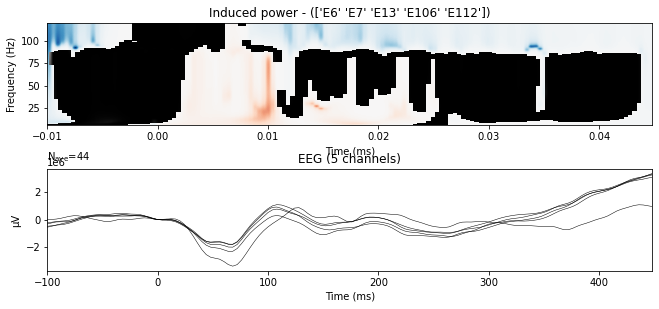

In [73]:
%matplotlib inline
conds_1 = {'Subject':'32','TOA_cond':'T','Vigilance':'Wn'}
conds_2 = {'Subject':'32','TOA_cond':'T','Vigilance':'N3'}
clusters, cluster_p_val = time_freq_clustr_perm(conds_1, conds_2, freqs, 'mean',n_cycles)

In [107]:
%matplotlib qt
min_freq = 0.1
decim = 2
freqs = np.arange(min_freq,50, 0.5)  # define frequencies of interest
n_cycles = freqs / 4.  # different number of cycle per frequency
conds_1 = {'Subject':'32','TOA_cond':'T','Vigilance':'Wn'}
time_freq_cond(conds_1,freqs)

Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
No baseline correction applied
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Plain as in MNE example - one electrode

In [78]:
conds_1 = {'Subject':'32','TOA_cond':'T','Vigilance':'Wn'}
conds_2 = {'Subject':'32','TOA_cond':'T','Vigilance':'N3'}
channel_num = 0
threshold = 6.0
p_value = 0.05
decim = 2
n_cycles = 1.5
freqs = np.arange(7, 120, 3)  # define frequencies of interest
n_permutations = 1000

def plain_mne_cluster_perm_one_electrodes():
    conds_df1, epochs_condition_1 = getEvokedPerCondAndElectd(conds_1,allEpochs_perCond,times, outputType='mne')
    conds_df2, epochs_condition_2 = getEvokedPerCondAndElectd(conds_2,allEpochs_perCond,times, outputType='mne')

    channel_name = cfg['ch_names'][channel_num]
    epochs_condition_1 = epochs_condition_1.pick_channels([channel_name])
    epochs_condition_2 = epochs_condition_2.pick_channels([channel_name])

    tfr_epochs_1 = tfr_morlet(epochs_condition_1, freqs, n_cycles=n_cycles, decim=decim,return_itc=False, average=False)
    tfr_epochs_2 = tfr_morlet(epochs_condition_2, freqs, n_cycles=n_cycles, decim=decim, return_itc=False, average=False)

    tfr_epochs_1.apply_baseline(mode='ratio', baseline=(None, 0))
    tfr_epochs_2.apply_baseline(mode='ratio', baseline=(None, 0))

    epochs_power_1 = tfr_epochs_1.data[:, channel_num, :, :]  # only 1 channel as 3D matrix
    epochs_power_2 = tfr_epochs_2.data[:, channel_num, :, :]  # only 1 channel as 3D matrix

    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([epochs_power_1, epochs_power_2], out_type='mask', n_permutations=n_permutations, threshold=threshold, tail=0)

    times_show = 1e3 * epochs_condition_1.times  # change unit to ms

    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
    fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_power_1 = epochs_power_1.mean(axis=0)
    evoked_power_2 = epochs_power_2.mean(axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2
    signs = np.sign(evoked_power_contrast)

    # Create new stats image with only significant clusters
    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= p_value:
            F_obs_plot[c] = F_obs[c] * signs[c]

    ax.imshow(F_obs,
              extent=[times_show[0], times_show[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='gray')
    max_F = np.nanmax(abs(F_obs_plot))
    ax.imshow(F_obs_plot,
              extent=[times_show[0], times_show[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='RdBu_r',
              vmin=-max_F, vmax=max_F)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Induced power ({channel_name})')

    #plot evoked
    evoked_condition_1 = epochs_condition_1.average()
    evoked_condition_2 = epochs_condition_2.average()
    evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2],weights=[1, -1])
    evoked_contrast.plot(axes=ax2, time_unit='s')
plain_mne_cluster_perm_one_electrodes()

Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
stat_fun(H1): min=0.000003 max=36.274221
Running initial clustering
Found 13 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Need more than one channel to make topography for eeg. Disabling interactivity.


Plain as in MNE example - mean electrodes

In [79]:
%matplotlib qt
conds_1 = {'TOA_cond':'T','Vigilance':'Wn'}
conds_2 = {'TOA_cond':'T','Vigilance':'N3'}
threshold = 10.0 # default 6
p_value = 0.05 # default 0.05
decim = 2# default 2
n_cycles = 1.5 # default 1.5
freqs = np.arange(7, 70, 3)  # define frequencies of interest
n_permutations=1000 # default 1000

def plain_mne_cluster_perm_mean():
    conds_df1, epochs_condition_1 = getEvokedPerCondAndElectd(conds_1,allEpochs_perCond,times, outputType='mne')
    conds_df2, epochs_condition_2 = getEvokedPerCondAndElectd(conds_2,allEpochs_perCond,times, outputType='mne')

    tfr_epochs_1 = tfr_morlet(epochs_condition_1, freqs, n_cycles=n_cycles, decim=decim,
                              return_itc=False, average=True)
    tfr_epochs_2 = tfr_morlet(epochs_condition_2, freqs, n_cycles=n_cycles, decim=decim,
                              return_itc=False, average=True)

    tfr_epochs_1.apply_baseline(mode='ratio', baseline=(None, 0))
    tfr_epochs_2.apply_baseline(mode='ratio', baseline=(None, 0))

    epochs_power_1 = tfr_epochs_1.data
    epochs_power_2 = tfr_epochs_2.data

    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([epochs_power_1, epochs_power_2], out_type='mask', n_permutations=n_permutations, threshold=threshold, tail=0)

    times_show = 1e3 * epochs_condition_1.times  # change unit to ms

    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
    fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_power_1 = epochs_power_1.mean(axis=0)
    evoked_power_2 = epochs_power_2.mean(axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2
    signs = np.sign(evoked_power_contrast)

    # Create new stats image with only significant clusters
    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= p_value:
            F_obs_plot[c] = F_obs[c] * signs[c]

    ax.imshow(F_obs,
              extent=[times_show[0], times_show[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='gray')
    max_F = np.nanmax(abs(F_obs_plot))
    ax.imshow(F_obs_plot,
              extent=[times_show[0], times_show[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='RdBu_r',
              vmin=-max_F, vmax=max_F)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Induced power mean electrodes')

    #plot evoked
    evoked_condition_1 = epochs_condition_1.average()
    evoked_condition_2 = epochs_condition_2.average()
    evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2],weights=[1, -1])
    evoked_contrast.plot(axes=ax2, time_unit='s')

plain_mne_cluster_perm_mean()

Not setting metadata
2492 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Not setting metadata
2520 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
stat_fun(H1): min=0.006164 max=3694.355349
Running initial clustering
Found 1 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


Not setting metadata
2492 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Not setting metadata
2520 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
stat_fun(H1): min=0.000013 max=59130.879308
Running initial clustering
Found 15 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
No baseline correction applied
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


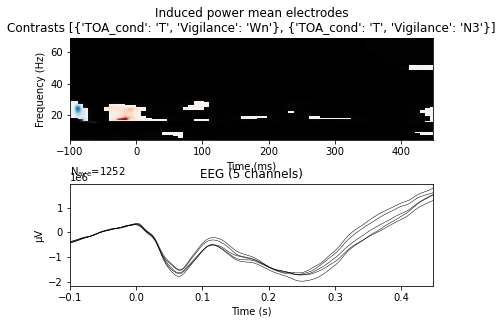

In [121]:
%matplotlib qt
cont_1 = {'TOA_cond':'T','Vigilance':'Wn'} #'Subject':'32'
cont_2 = {'TOA_cond':'T','Vigilance':'N3'}

threshold = 1000.0 # default 6

#### Right decisions:
# ==================
# zscore baseline
## Tail is 0, so the statistic is thresholded on both sides of the distribution.
baseline = (None, 0)
p_value = 0.05 # default 0.05
decim = 2# default 2 for testing.. For reals - 1
n_permutations=1000 # default 1k for testing. For reals - 10K
min_freq = 4
freqs = np.arange(min_freq,70, 1)  # define frequencies of interest
# another option:
n_cycles = freqs / min_freq # different number of cycle per frequency


contrasts = [cont_1, cont_2]
epochs_power = []
epochs_condition = []
tfrs_epochs_avg = []
tfrs_epochs = []

for c_i, contrast in enumerate(contrasts):
    conds_df, cont_epochs = getEvokedPerCondAndElectd(contrast,allEpochs_perCond,times, outputType='mne')
    tfr_epochs_avg = tfr_morlet(cont_epochs, freqs, n_cycles=n_cycles, decim=decim, average=True, return_itc=False)
    tfr_epochs = tfr_morlet(cont_epochs, freqs=freqs, n_cycles=n_cycles, decim=decim, average=True, return_itc=False)
    tfr_epochs_avg.apply_baseline(mode='zscore', baseline=baseline)
    tfr_epochs.apply_baseline(mode='zscore', baseline=baseline)

    epochs_power.append(tfr_epochs.data)
    epochs_condition.append(cont_epochs)
    tfrs_epochs.append(tfr_epochs)
    tfrs_epochs_avg.append(tfr_epochs_avg)

F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(epochs_power, out_type='mask', n_permutations=n_permutations, threshold=threshold, tail=0,verbose=True)

#plot
# ============================

times_show = 1e3 * epochs_condition[0].times  # change unit to ms


tfrs_epochs[0].plot_topo(title=f'Average power, {contrasts[0]}')
fig, axis = plt.subplots(1, len(freq_bands)+1, figsize=(20, 4))
for f_i, freq_band in enumerate(freq_bands.values()):
    tfrs_epochs[0].plot_topomap(ch_type='eeg', tmin=times_show[0], tmax=times_show[-1], fmin=freq_band['min'], fmax=freq_band['max'], baseline=baseline, axes=axis[f_i], title=freq_band['title'])
tfrs_epochs[0].plot_topomap(ch_type='eeg', tmin=times_show[0], tmax=times_show[-1], fmin=freqs[0], fmax=freqs[-1],baseline=baseline,  axes=axis[len(freq_bands)], title=f'All range ({freqs[0]}-{freqs[-1]} Hz)')
mne.viz.tight_layout()
plt.show()

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = epochs_power[0].mean(axis=0)
evoked_power_2 = epochs_power[1].mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= p_value:
        F_obs_plot[c] = F_obs[c] * signs[c]

times_show = 1e3 * epochs_condition[0].times  # change unit to ms
ax.imshow(F_obs,
          extent=[times_show[0], times_show[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower', cmap='gray')
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(F_obs_plot,
          extent=[times_show[0], times_show[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower', cmap='RdBu_r',
          vmin=-max_F, vmax=max_F)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Induced power mean electrodes\nContrasts {contrasts}')

#plot evoked
evoked_condition_1 = epochs_condition[0].average()
evoked_condition_2 = epochs_condition[1].average()
evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2],weights=[1, -1])
evoked_contrast.plot(axes=ax2, time_unit='s')